In [28]:
# Gerekli kütüphaneleri yükle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import base64
import io
import cv2
from PIL import Image
import seaborn as sns
import logging



In [4]:

# Model yükleme
model = tf.keras.models.load_model('model.h5')
print("Model başarıyla yüklendi!")
model.summary()


Model başarıyla yüklendi!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,036 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [20]:

# Model'i initialize et ve input layer'ı manuel olarak tanımla
dummy_input = tf.zeros((1, 28, 28, 1))
_ = model(dummy_input)

# Katman görselleştirmesi için yardımcı model oluştur (tamamen düzeltilmiş versiyon)
def create_layer_visualization_model(model):
    # Input layer'ı manuel olarak oluştur
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
    
    # Model'in katmanlarını yeniden bağla
    x = input_layer
    layer_outputs = []
    layer_names = []
    
    for layer in model.layers:
        x = layer(x)
        if 'conv' in layer.name or 'dense' in layer.name:
            layer_outputs.append(x)
            layer_names.append(layer.name)
    
    print(f"Bulunan katmanlar: {layer_names}")
    
    return Model(inputs=input_layer, outputs=layer_outputs)

viz_model = create_layer_visualization_model(model)
print(f"Görselleştirme modeli oluşturuldu. {len(viz_model.outputs)} katman çıktısı izlenecek.")


Bulunan katmanlar: ['conv2d_4', 'conv2d_5', 'dense_4', 'dense_5']
Görselleştirme modeli oluşturuldu. 4 katman çıktısı izlenecek.


In [29]:
def preprocess_image_for_model(img_bytes: bytes):
    """
    Process image bytes for MNIST digit recognition model using OpenCV.
    """
    img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_UNCHANGED)

    if img is None:
        print("⚠️ cv2.imdecode ile resim yüklenemedi.")
        return None

    if len(img.shape) == 3 and img.shape[2] == 4:
        gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
        alpha = img[:, :, 3]
        gray[alpha == 0] = 255
        processed = gray
    elif len(img.shape) == 3:
        processed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        processed = img

    image_size = (28, 28)
    processed = cv2.resize(processed, image_size)

    # Renkleri tersine çevir
    processed = 255 - processed

    processed = processed.astype('float32') / 255.0

    processed = np.expand_dims(processed, axis=0)
    processed = np.expand_dims(processed, axis=-1)

    return processed


Test görüntüsü başarıyla yüklendi!
Görüntü boyutu: (319, 304)
Görüntü işleme başarılı!
İşlenmiş görüntü boyutu: (1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tahmin: 2, Güven: %100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
=== TAHMİN OLASILILIKLARI ===
Tahmin: 2, Güven: %100.00
Tüm olasılıklar: ['0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']

=== FEATURE MAPS (İlk Conv Katmanı) ===


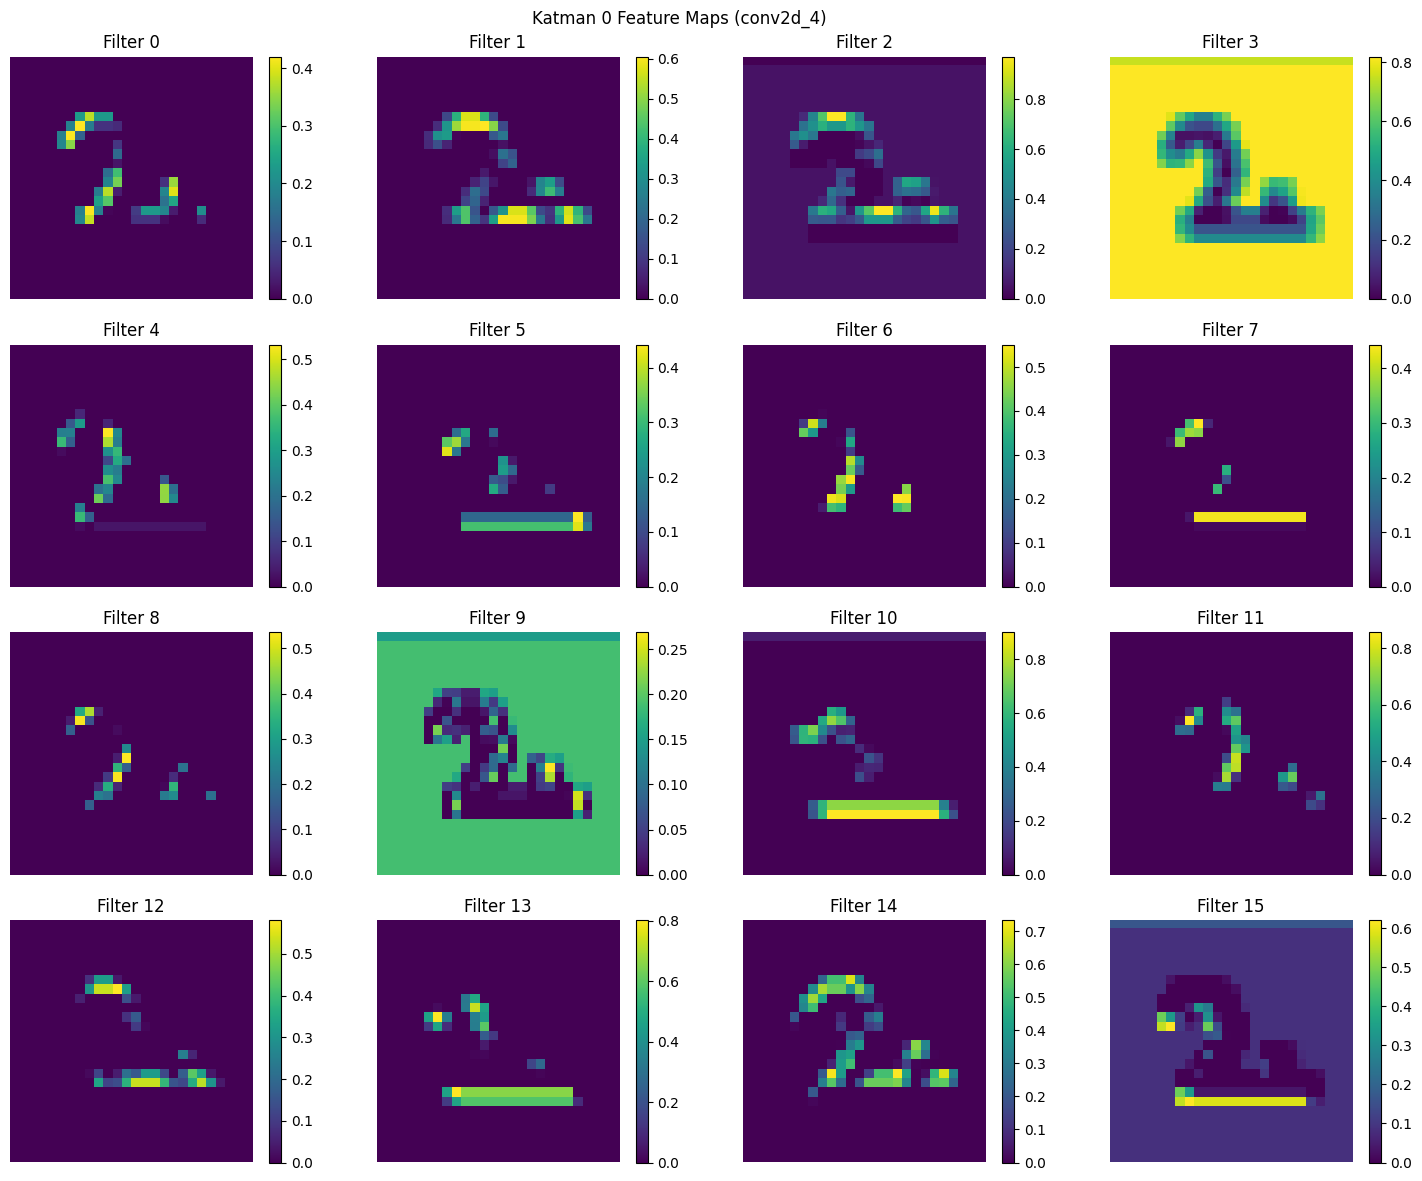

Mevcut test görüntüsü analizi:

Yüklenen test görüntüsü:
Tahmin: 2, Güven: %100.00
Tüm olasılıklar: ['0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']


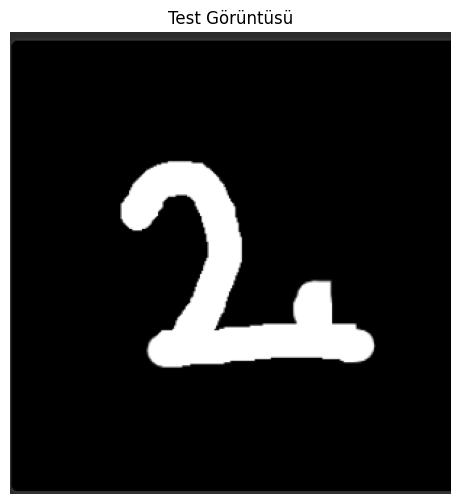

In [40]:
import cv2

# Test verisi oluştur (el yazısı benzeri)
test_img = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)
if test_img is None:
    print("Test görüntüsü bulunamadı! Lütfen doğru yolu kontrol edin.")
    # Yedek test görüntüsü oluştur
    test_img = np.ones((28, 28), dtype=np.uint8) * 255
    # Daha iyi 4 rakamı çiz
    test_img[6:22, 4:7] = 0      # Sol dikey çizgi
    test_img[13:16, 4:18] = 0    # Yatay çizgi  
    test_img[13:22, 15:18] = 0   # Sağ dikey çizgi (sadece alt kısım)
else:
    print("Test görüntüsü başarıyla yüklendi!")
    print(f"Görüntü boyutu: {test_img.shape}")

# Test görüntüsünü model için işleme
_, img_encoded = cv2.imencode('.png', test_img)
test_img_processed = preprocess_image_for_model(img_encoded.tobytes())

if test_img_processed is None:
    print("Görüntü işleme başarısız oldu!")
else:
    print("Görüntü işleme başarılı!")
    print(f"İşlenmiş görüntü boyutu: {test_img_processed.shape}")

# Model tahminini al
predictions = model.predict(test_img_processed)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])

print(f"Tahmin: {predicted_class}, Güven: %{confidence*100:.2f}")

# Katman çıktılarını al
layer_outputs = viz_model.predict(test_img_processed)

# Görselleştirme fonksiyonları
def plot_original_and_prediction():
    """Orijinal görüntü ve tahmin sonuçlarını göster"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Orijinal görüntü
    ax1.imshow(test_img, cmap='gray')
    ax1.set_title('Test Görüntüsü')
    ax1.axis('off')
    
    # Tahmin olasılıkları
    ax2.bar(range(10), predictions[0])
    ax2.set_title(f'Tahmin Olasılıkları (Tahmin: {predicted_class})')
    ax2.set_xlabel('Rakam')
    ax2.set_ylabel('Olasılık')
    ax2.set_xticks(range(10))
    
    plt.tight_layout()
    plt.show()

def plot_feature_maps(layer_index=0, max_filters=16):
    """Belirli bir katmanın feature map'lerini göster"""
    if layer_index >= len(layer_outputs):
        print(f"Geçersiz katman indeksi! Mevcut katman sayısı: {len(layer_outputs)}")
        return
    
    feature_maps = layer_outputs[layer_index]
    
    if len(feature_maps.shape) != 4:
        print(f"Bu katman konvolüsyon katmanı değil. Shape: {feature_maps.shape}")
        return
    
    num_filters = min(feature_maps.shape[-1], max_filters)
    cols = 4
    rows = (num_filters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows*3))
    fig.suptitle(f'Katman {layer_index} Feature Maps ({model.layers[layer_index].name})')
    
    for i in range(num_filters):
        row = i // cols
        col = i % cols
        
        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col] if cols > 1 else axes
        
        feature_map = feature_maps[0, :, :, i]
        im = ax.imshow(feature_map, cmap='viridis')
        ax.set_title(f'Filter {i}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Boş subplot'ları gizle
    for i in range(num_filters, rows * cols):
        row = i // cols
        col = i % cols
        if rows > 1:
            axes[row, col].axis('off')
        else:
            if cols > 1:
                axes[col].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_conv_filters():
    """İlk konvolüsyon katmanının filtrelerini göster"""
    conv_layer = None
    for layer in model.layers:
        if 'conv' in layer.name:
            conv_layer = layer
            break
    
    if conv_layer is None:
        print("Konvolüsyon katmanı bulunamadı!")
        return
    
    filters = conv_layer.get_weights()[0]  # [height, width, input_channels, output_channels]
    
    num_filters = min(filters.shape[-1], 32)
    cols = 8
    rows = (num_filters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows*2))
    fig.suptitle(f'{conv_layer.name} Katmanının Filtreleri')
    
    for i in range(num_filters):
        row = i // cols
        col = i % cols
        
        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
        
        filter_img = filters[:, :, 0, i]
        ax.imshow(filter_img, cmap='gray')
        ax.set_title(f'F{i}')
        ax.axis('off')
    
    # Boş subplot'ları gizle
    for i in range(num_filters, rows * cols):
        row = i // cols
        col = i % cols
        if rows > 1:
            axes[row, col].axis('off')
        else:
            axes[col].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_layer_activations():
    """Tüm katmanların aktivasyon istatistiklerini göster"""
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'dense' in layer.name]
    
    print("Katman Aktivasyon Analizi:")
    print("-" * 50)
    
    for i, (output, name) in enumerate(zip(layer_outputs, layer_names)):
        mean_activation = np.mean(output)
        std_activation = np.std(output)
        max_activation = np.max(output)
        min_activation = np.min(output)
        
        print(f"{name}:")
        print(f"  Shape: {output.shape}")
        print(f"  Mean: {mean_activation:.4f}")
        print(f"  Std: {std_activation:.4f}")
        print(f"  Min/Max: {min_activation:.4f}/{max_activation:.4f}")
        print()

# Sadece tahmin olasılıkları ve feature maps
print("=== TAHMİN OLASILILIKLARI ===")
print(f"Tahmin: {predicted_class}, Güven: %{confidence*100:.2f}")
print(f"Tüm olasılıklar: {[f'{p:.3f}' for p in predictions[0]]}")

print("\n=== FEATURE MAPS (İlk Conv Katmanı) ===")
plot_feature_maps(0)


# interactive_visualization fonksiyonunu da düzeltelim
def interactive_visualization():
    """Farklı test görüntüleri için interaktif görselleştirme"""
    print("Mevcut test görüntüsü analizi:")
    
    # Gerçek test görüntüsünü analiz et
    print(f"\nYüklenen test görüntüsü:")
    print(f"Tahmin: {predicted_class}, Güven: %{confidence*100:.2f}")
    print(f"Tüm olasılıklar: {[f'{p:.3f}' for p in predictions[0]]}")

interactive_visualization()

plt.figure(figsize=(6, 6))
plt.imshow(test_img, cmap='gray')
plt.title('Test Görüntüsü')
plt.axis('off')
plt.show()



=== SİNİR AĞI GÖRSELLEŞTİRMESİ ===


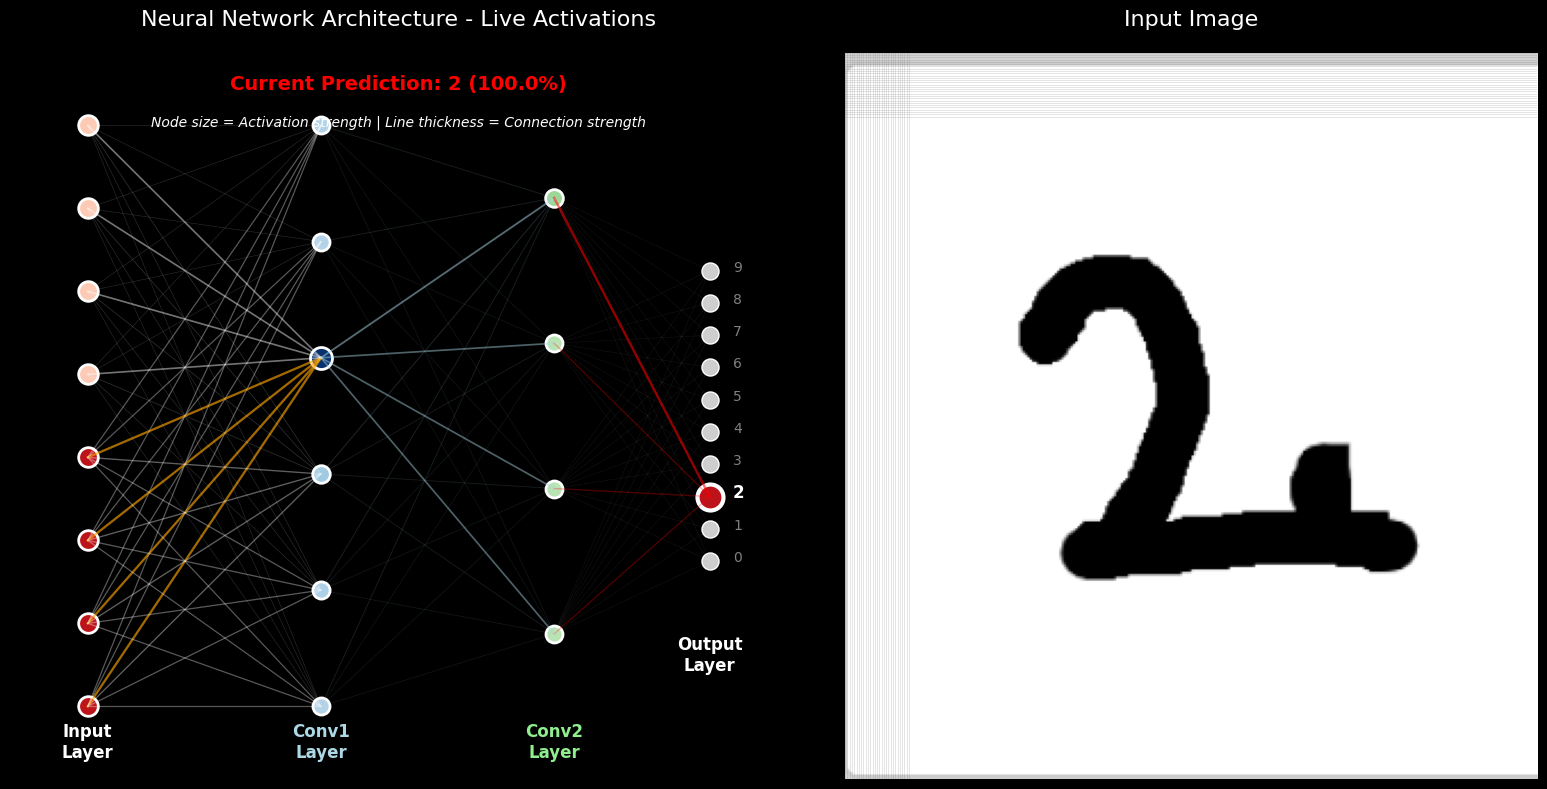


=== GELİŞMİŞ MODEL ARŞİTEKTÜRÜ ===


C:\Users\firat\AppData\Local\Temp\ipykernel_32072\2707498732.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


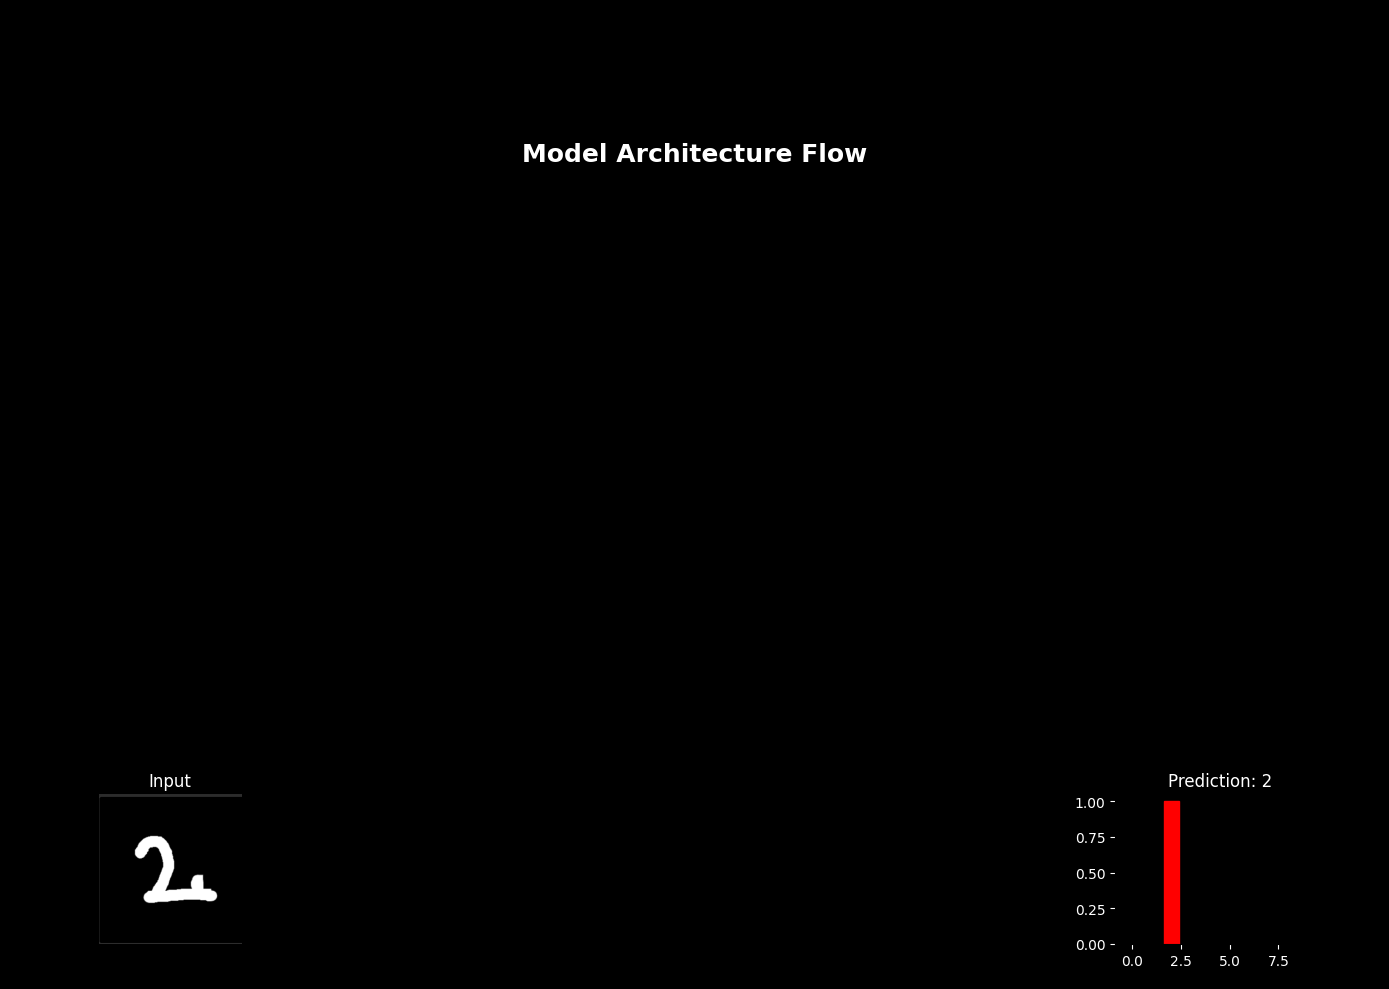


=== FEATURE MAP GÖRSELLEŞTİRMESİ ===


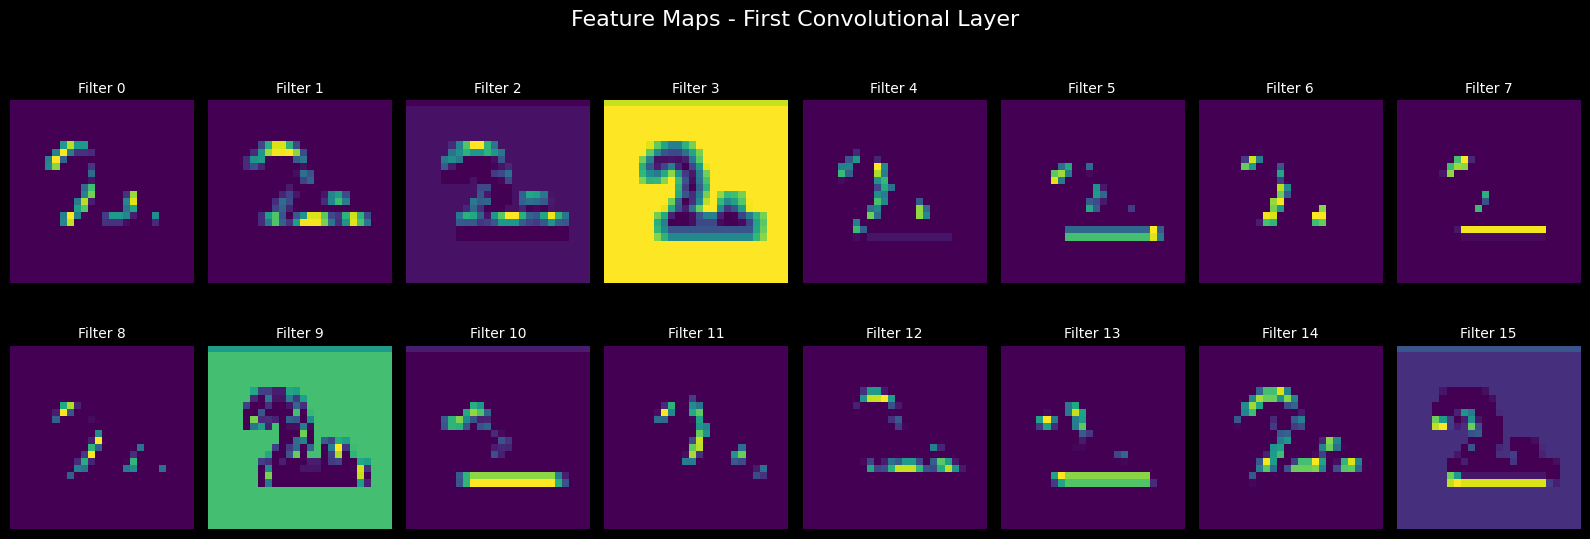

In [ ]:
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import networkx as nx

def create_neural_network_visualization():
    """Kompakt sinir ağı görselleştirmesi - Ok gösterimleri ile"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.patch.set_facecolor('black')
    
    # Sol taraf - Kompakt sinir ağı yapısı
    ax1.set_facecolor('black')
    ax1.set_xlim(0, 8)
    ax1.set_ylim(0, 6)
    ax1.axis('off')
    ax1.set_title('Neural Network - Live Activations', color='white', fontsize=14, pad=15)
    
    # Kompakt pozisyonlar
    input_positions = [(1, i) for i in np.linspace(1.5, 4.5, 4)]
    hidden1_positions = [(3, i) for i in np.linspace(1.5, 4.5, 3)]
    hidden2_positions = [(5, i) for i in np.linspace(2, 4, 2)]
    output_positions = [(7, i) for i in np.linspace(1, 5, 5)]
    
    # Layer çıktılarından aktivasyon değerlerini al
    if len(layer_outputs) >= 2:
        conv1_activations = layer_outputs[0][0].mean(axis=(0,1))[:3]
        conv2_activations = layer_outputs[1][0].mean(axis=(0,1))[:2] if len(layer_outputs) > 1 else np.ones(2) * 0.5
        conv1_norm = (conv1_activations - conv1_activations.min()) / (conv1_activations.max() - conv1_activations.min() + 1e-8)
        conv2_norm = (conv2_activations - conv2_activations.min()) / (conv2_activations.max() - conv2_activations.min() + 1e-8)
    else:
        conv1_norm = np.random.random(3) * 0.5 + 0.3
        conv2_norm = np.random.random(2) * 0.5 + 0.3
    
    # Input nöronları - kompakt
    for i, pos in enumerate(input_positions):
        activation = 0.7 if i < 2 else 0.3
        color = plt.cm.Reds(0.3 + activation * 0.7)
        ax1.scatter(pos[0], pos[1], s=80, c=[color], edgecolors='white', linewidth=1.5)
    
    # Hidden layer 1
    for i, pos in enumerate(hidden1_positions):
        activation = conv1_norm[i] if i < len(conv1_norm) else 0.3
        color = plt.cm.Blues(0.3 + activation * 0.7)
        size = 60 + activation * 40
        ax1.scatter(pos[0], pos[1], s=size, c=[color], edgecolors='white', linewidth=1.5)
    
    # Hidden layer 2
    for i, pos in enumerate(hidden2_positions):
        activation = conv2_norm[i] if i < len(conv2_norm) else 0.3
        color = plt.cm.Greens(0.3 + activation * 0.7)
        size = 60 + activation * 40
        ax1.scatter(pos[0], pos[1], s=size, c=[color], edgecolors='white', linewidth=1.5)
    
    # Output nöronları - top 5 probabilities
    top_indices = np.argsort(predictions[0])[-5:][::-1]
    for i, pos in enumerate(output_positions):
        idx = top_indices[i]
        probability = predictions[0][idx]
        
        if idx == predicted_class:
            color = plt.cm.Reds(0.8)
            size = 100 + probability * 50
            ax1.scatter(pos[0], pos[1], s=size, c=[color], edgecolors='white', linewidth=2)
            ax1.text(pos[0]+0.2, pos[1], str(idx), color='white', fontsize=10, fontweight='bold')
        else:
            color = plt.cm.Greys(0.3 + probability * 2)
            size = 60 + probability * 30
            ax1.scatter(pos[0], pos[1], s=size, c=[color], edgecolors='white', linewidth=1)
            ax1.text(pos[0]+0.2, pos[1], str(idx), color='gray', fontsize=8)
    
    # Ok gösterimleri - Layer'lar arası
    # Input -> Hidden1
    arrow1 = FancyArrowPatch((1.8, 3), (2.2, 3), 
                            arrowstyle='->', mutation_scale=20, 
                            color='orange', linewidth=2, alpha=0.8)
    ax1.add_patch(arrow1)
    
    # Hidden1 -> Hidden2
    arrow2 = FancyArrowPatch((3.8, 3), (4.2, 3), 
                            arrowstyle='->', mutation_scale=20, 
                            color='yellow', linewidth=2, alpha=0.8)
    ax1.add_patch(arrow2)
    
    # Hidden2 -> Output
    arrow3 = FancyArrowPatch((5.8, 3), (6.2, 3), 
                            arrowstyle='->', mutation_scale=20, 
                            color='red', linewidth=3, alpha=0.9)
    ax1.add_patch(arrow3)
    
    # Kompakt layer labels
    ax1.text(1, 0.8, 'Input', color='white', ha='center', fontsize=10, fontweight='bold')
    ax1.text(3, 0.8, 'Conv1', color='lightblue', ha='center', fontsize=10, fontweight='bold')
    ax1.text(5, 0.8, 'Conv2', color='lightgreen', ha='center', fontsize=10, fontweight='bold')
    ax1.text(7, 0.8, 'Output', color='white', ha='center', fontsize=10, fontweight='bold')
    
    # Kompakt tahmin bilgisi
    ax1.text(4, 5.5, f'Prediction: {predicted_class} ({confidence*100:.1f}%)', 
             color='red', ha='center', fontsize=12, fontweight='bold')
    
    # Sağ taraf - Test görüntüsü (daha küçük)
    ax2.set_facecolor('black')
    ax2.imshow(test_img, cmap='gray_r')
    ax2.set_title('Input Image', color='white', fontsize=14, pad=15)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def create_compact_feature_map():
    """Kompakt feature map görselleştirmesi"""
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
    fig.patch.set_facecolor('black')
    fig.suptitle('Top Feature Maps', color='white', fontsize=12)
    
    feature_maps = layer_outputs[0]
    
    for i in range(4):
        ax = axes[i]
        ax.set_facecolor('black')
        
        if i < feature_maps.shape[-1]:
            im = ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
            ax.set_title(f'F{i}', color='white', fontsize=9)
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Kompakt görselleştirmeleri çalıştır
print("=== KOMPAKT SİNİR AĞI GÖRSELLEŞTİRMESİ ===")
create_neural_network_visualization()

print("\n=== KOMPAKT FEATURE MAP ===")
create_compact_feature_map()

In [48]:
# Test: Layer aktivasyonlarını kontrol et
print("=== KATMAN AKTİVASYONU TEST ===")

# Visualization model'den katman çıktılarını al
layer_outputs = viz_model.predict(test_img_processed)
print(f"Katman çıktısı sayısı: {len(layer_outputs)}")

for i, output in enumerate(layer_outputs):
    print(f"Katman {i}: shape={output.shape}, mean={np.mean(output):.4f}, std={np.std(output):.4f}")
    
    # Her katman için aktivasyon özetini çıkar (Frontend için)
    if len(output.shape) == 4:  # Conv layer
        channel_means = np.mean(output[0], axis=(0, 1))
        # Normalize et
        if np.max(channel_means) > np.min(channel_means):
            normalized = (channel_means - np.min(channel_means)) / (np.max(channel_means) - np.min(channel_means))
        else:
            normalized = channel_means
        activation_summary = normalized.tolist()[:16]
        print(f"  Conv aktivasyon özeti (ilk 16): {[f'{x:.3f}' for x in activation_summary]}")
        
    elif len(output.shape) == 2:  # Dense layer  
        activations = output[0]
        # Normalize et
        if np.max(activations) > np.min(activations):
            normalized = (activations - np.min(activations)) / (np.max(activations) - np.min(activations))
        else:
            normalized = activations
        activation_summary = normalized.tolist()[:16]
        print(f"  Dense aktivasyon özeti (ilk 16): {[f'{x:.3f}' for x in activation_summary]}")

print("\n=== JSON FORMAT OUTPUT ===")
# Frontend için JSON formatı
frontend_data = {
    "prediction": int(predicted_class),
    "confidence": float(confidence),
    "probabilities": predictions[0].tolist(),
    "layer_activations": []
}

for i, output in enumerate(layer_outputs):
    if len(output.shape) == 4:  # Conv layer
        channel_means = np.mean(output[0], axis=(0, 1))
        if np.max(channel_means) > np.min(channel_means):
            normalized = (channel_means - np.min(channel_means)) / (np.max(channel_means) - np.min(channel_means))
        else:
            normalized = channel_means
        activation_summary = normalized.tolist()[:16]
    elif len(output.shape) == 2:  # Dense layer
        activations = output[0]
        if np.max(activations) > np.min(activations):
            normalized = (activations - np.min(activations)) / (np.max(activations) - np.min(activations))
        else:
            normalized = activations
        activation_summary = normalized.tolist()[:16]
    else:
        activation_summary = [float(np.mean(output))]
    
    layer_info = {
        "layer_index": i,
        "layer_name": viz_model.layers[i+1].name if i+1 < len(viz_model.layers) else f"layer_{i}",
        "activations": activation_summary
    }
    frontend_data["layer_activations"].append(layer_info)

import json
print(json.dumps(frontend_data, indent=2))

=== KATMAN AKTİVASYONU TEST ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Katman çıktısı sayısı: 4
Katman 0: shape=(1, 26, 26, 32), mean=0.0674, std=0.1683
  Conv aktivasyon özeti (ilk 16): ['0.012', '0.036', '0.106', '1.000', '0.011', '0.013', '0.012', '0.009', '0.005', '0.212', '0.062', '0.020', '0.014', '0.043', '0.046', '0.121']
Katman 1: shape=(1, 11, 11, 64), mean=0.0385, std=0.2671
  Conv aktivasyon özeti (ilk 16): ['0.000', '0.000', '0.000', '0.126', '0.000', '0.000', '0.142', '0.000', '0.000', '0.381', '1.000', '0.251', '0.109', '0.000', '0.000', '0.000']
Katman 2: shape=(1, 128), mean=1.4011, std=2.9251
  Dense aktivasyon özeti (ilk 16): ['0.000', '0.008', '0.676', '0.158', '0.000', '0.549', '0.000', '0.000', '0.000', '0.000', '0.000', '0.258', '0.678', '0.000', '0.029', '0.563']
Katman 3: shape=(1, 10), mean=0.1000, std=0.3000
  Dense aktivasyon özeti (ilk 16): ['0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']

=== JSON FORMAT OUTPUT ===
